In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
import os
import random
from keras.applications.resnet import preprocess_input
from keras_preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split


In [2]:
dir = Path('Fish_Dataset/Fish_Dataset')


In [3]:
filepaths = list(dir.glob(r'**/*.png'))

In [4]:
labels = list(map(lambda l: os.path.split(os.path.split(l)[0])[1], filepaths))

In [5]:
df = pd.DataFrame({'filepaths':filepaths, 'labels':labels})
df = df[df['labels'].apply(lambda l: l[-2:] != 'GT')]
df = df.sample(frac=1).reset_index(drop=True)

In [6]:
df = df.astype({"filepaths": str, "labels": str})


In [7]:
df.labels.value_counts()

Red Mullet            1000
Sea Bass              1000
Trout                 1000
Hourse Mackerel       1000
Black Sea Sprat       1000
Red Sea Bream         1000
Shrimp                1000
Gilt-Head Bream       1000
Striped Red Mullet    1000
Name: labels, dtype: int64

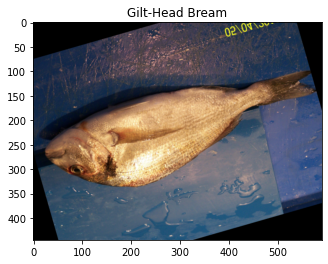

In [8]:
rand = random.randint(0,len(df))
plt.imshow(plt.imread(df.filepaths[rand]))
plt.title(df.labels[rand])
plt.show()

In [9]:
train_df, test_df = train_test_split(df, test_size=0.2, stratify=df['labels'])


In [10]:

img_data_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

train_data = img_data_gen.flow_from_dataframe(dataframe=train_df,
                                          x_col='filepaths',
                                          y_col='labels',
                                        classes = list(df.labels),
                                          target_size=(224,224),
                                          color_mode='rgb',
                                          class_mode='categorical',
                                          batch_size=32,
                                          seed=42)


test_data = img_data_gen.flow_from_dataframe(dataframe=test_df,
                                          x_col='filepaths',
                                          y_col='labels',
                                        classes = list(df.labels),
                                          target_size=(224,224),
                                          color_mode='rgb',
                                          class_mode='categorical',
                                          batch_size=32,
                                          seed=42)

Found 7200 validated image filenames belonging to 9 classes.
Found 1800 validated image filenames belonging to 9 classes.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


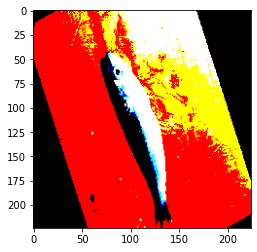

In [11]:
plt.imshow(train_data[0][0][1,:])

In [12]:
train_data[0][0].shape

(32, 224, 224, 3)

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(224, 224, 3)),
    tf.keras.layers.Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_uniform'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation = 'relu'),
    tf.keras.layers.Dense(9,activation = 'softmax')
])

model.compile(loss = tf.keras.losses.CategoricalCrossentropy(),
              optimizer = tf.keras.optimizers.Adam(),
              metrics = ['accuracy']
              
             )

callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                              patience=3)

history = model.fit(train_data,epochs = 2,validation_data = (test_data), callbacks = [callback])

Epoch 1/2
 99/225 [============>.................] - ETA: 1:49 - loss: 1.8063 - accuracy: 0.4470 

In [ ]:
model.predict(np.expand_dims(test_data[0][0][0], axis=0))

In [ ]:
model.summary()

In [ ]:
test_preds = model.predict(test_data)
test_preds_num = [tf.argmax(x).numpy() for x in test_preds]

In [ ]:
test_preds[0]


In [ ]:

rand = random.randint(0,len(test_data))
im_pred = tf.argmax(model.predict(np.expand_dims(test_data[rand][0][1,:], axis = 0))[0]).numpy()

plt.imshow(np.array(test_data[rand][0][1,:]))
plt.title(im_pred)
plt.show()

In [ ]:
list(df.labels)